In [14]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

import sys
import os
sys.path.append(os.path.abspath('../..'))
from project_paths import PROJECT_ROOT
from file_handler import GradHandler
from Paper.figure_scripts import common

In [15]:
L = 64
alpha = 1
arch = f"RBM_alpha{alpha}"
n_dim = 1
PBC = True
model_labels = ["TFIM", "Heisenberg"]
model_params = [{"J": 1, "h": 0.5}, {"J": 1}]

folder = f"{PROJECT_ROOT}Data/Gradients/MC_LPE_driver/"

In [16]:
grads = []

for m in range(len(model_labels)):
    gh = GradHandler(folder, model_labels[m], arch, L, PBC, n_dim, **model_params[m])
    grads.append(gh.load_gradients_flattened())
grads = np.array(grads).reshape((len(model_labels), -1))

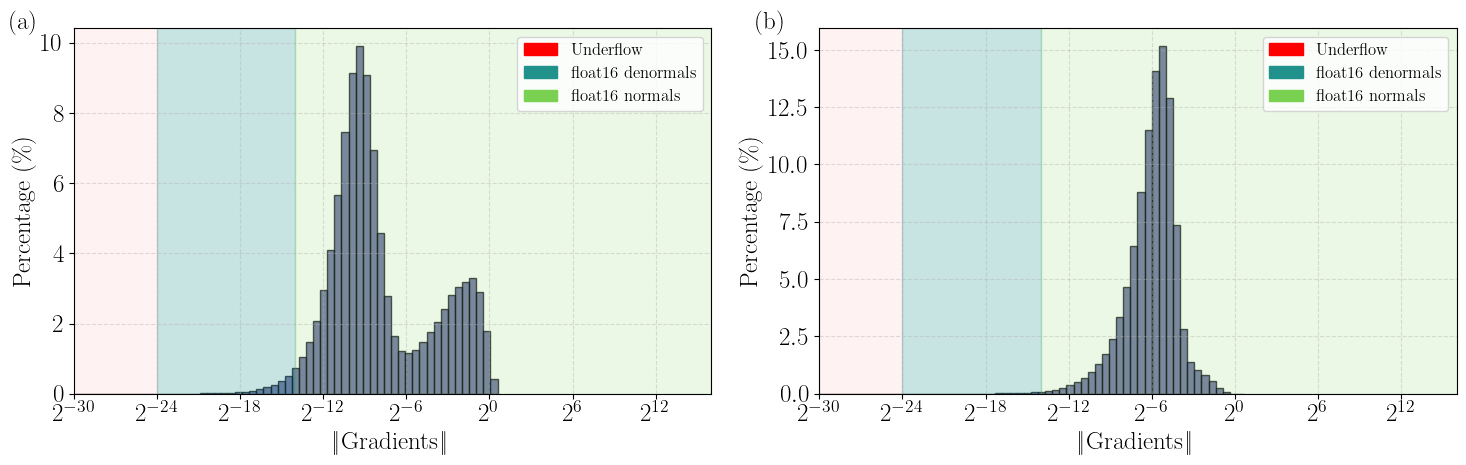

In [17]:
plt.figure(figsize=(15, 5))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, 3))

float16_min_norm = 2**-14      
float16_min_sub = 2**-24        
float16_max = 65504
n_parameters = L ** 2 + L * 2
last_epoch = 1000
first_epoch = 0

for i, (grads_m, label) in enumerate(zip(grads, model_labels)):
    plt.subplot(1, len(model_labels), i + 1)
    plt.text(-0.1, 1.05, f'({chr(97 + i)})', transform=plt.gca().transAxes, fontweight='bold', va='top')

    abs_grads = np.abs(grads_m[first_epoch * n_parameters:last_epoch * n_parameters])
    bins = np.logspace(np.log2(1e-12), np.log2(np.max(abs_grads) + 1e-12), 80, base=2)

    counts, bin_edges = np.histogram(abs_grads, bins=bins)
    percentages = counts / counts.sum() * 100 

    plt.bar(
        bin_edges[:-1],
        percentages,
        width=np.diff(bin_edges),
        align='edge',
        color=colors[0],
        alpha=0.7,
        edgecolor='black'
    )

    plt.axvspan(float16_min_sub, float16_min_norm, color=colors[1], alpha=0.25)
    plt.axvspan(float16_min_norm, float16_max, color=colors[2], alpha=0.15)
    plt.axvspan(1e-12, float16_min_sub, color='red', alpha=0.05)

    legend_patches = [
        mpatches.Patch(color='red', alpha=1, label='Underflow'),
        mpatches.Patch(color=colors[1], alpha=1, label='float16 denormals'),
        mpatches.Patch(color=colors[2], alpha=1, label='float16 normals'),
    ]
    plt.legend(handles=legend_patches, frameon=True)

    plt.xscale('log', base=2)
    plt.xlabel("‖Gradients‖")
    plt.ylabel("Percentage (\%)")
    plt.grid(True, which="both", ls="--", alpha=0.4)
    plt.xlim(2**(-30), float16_max)

plt.tight_layout()
plt.savefig('figures/dynamic_range.pdf')
plt.show()